<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
# N_SAMPLES_TRAIN = 2000
# N_SAMPLES_VALID = 1000

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_train = df_train

df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]
df_validation = df_validation

values_to_predict = ['x', 'y', 'u', 'v']

IMG_SIZE = 128
BATCH_SIZE = 512

#Try std normalization and zero mean dataset, 
#learn std and mean from train and use for validation
#VERIFICARE SE FANNO LO SHUFFLE

train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

Found 10259 validated image filenames.
Found 3101 validated image filenames.


In [ ]:
print(df_validation.shape)

(3101, 3)


# **Visualizing some images**

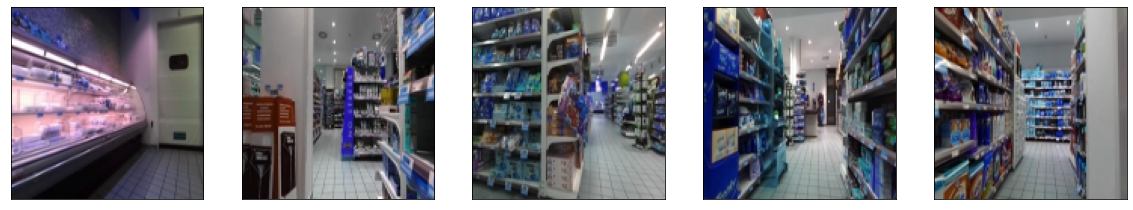

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
files_train = train[:,0]
np.random.shuffle(files_train)

x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
print(files_train)

['2L010440.jpg' '1L010820.jpg' '1L020300.jpg' ... '1L036440.jpg'
 '4L017600.jpg' '050520.jpg']


# **Training the model**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, BatchNormalization, Dropout, ReLU
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError

# model = Sequential([
#             Conv2D(8, (3,3), activation = 'relu', padding='same',
#                 input_shape = (IMG_SIZE,IMG_SIZE,3)),
#             MaxPooling2D((4, 4), padding='same'),#8x8x8
#             Flatten(),
#             Dense(4, activation="relu")                                       
# ])

model = Sequential([
            Conv2D(16, (3,3), padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),          
            # Conv2D(16, (5, 5), activation='relu', padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.4),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(32, (3, 2), padding='same'),
            # Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.5),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(32, (3, 3), padding='same'),
            # Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.6),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.7),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.8),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(256, (3, 3), padding='same'),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.9),
            MaxPooling2D((2, 2), padding='same'),

            Flatten(),
            Dense(4),
            BatchNormalization(),
            ReLU(),
            Dropout(rate=0.9),
            # Dense(512),
            # Dense(4) #Linear activation to obtain full range [-inf, +inf] bc of regression
])

model.summary()

optim = SGD(learning_rate=0.01, momentum=0.9)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
re_lu_31 (ReLU)              (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 32)        3104      
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 64, 32)       

In [ ]:


history = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    workers = 8)


# steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
# validation_steps = df_validation.shape[0]/BATCH_SIZE,

Epoch 1/5
21/20 [===============================] - 28s 1s/step - loss: 44.2279 - val_loss: 196.9534
Epoch 2/5


KeyboardInterrupt: ignored

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss = np.array(loss, dtype=np.float32)
val_loss = np.array(val_loss, dtype=np.float32)

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

NameError: ignored

In [ ]:
print(acc[1])

0.7020000219345093


CARICAMENTO DATASET

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

flow_from_dataframe mi permette di usare direttamente il csv per costruire i dataloaders

Tutorial
https://www.youtube.com/watch?v=uqomO_BZ44g&ab_channel=WhenMathsmeetscoding

https://www.youtube.com/watch?v=_L2uYfVV48I&ab_channel=deeplizard